In [1]:
# !pip install sbi

import torch
import numpy as np
from scipy.signal import welch
from sbi import utils as sbi_utils
from sbi.inference import SNPE
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
from tensorflow.keras.models import load_model

generator = load_model("saved_models/qpo_cgan_phy_generator.keras")


🧠 Running simulations...
 Neural network successfully converged after 34 epochs.✅ SBI posterior trained!


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

          True_fc  Estimated_fc    True_amp  Estimated_amp    fc_error  \
count  100.000000    100.000000  100.000000     100.000000  100.000000   
mean     0.263311      0.248235    0.536222       0.554716    0.112676   
std      0.133248      0.010272    0.269742       0.029171    0.072955   
min      0.014555      0.222376    0.115513       0.495928    0.004489   
25%      0.154886      0.241702    0.299808       0.535479    0.045744   
50%      0.270122      0.248370    0.529165       0.550107    0.111223   
75%      0.358354      0.255546    0.773673       0.572295    0.174806   
max      0.497801      0.276938    0.998501       0.629313    0.254342   

        amp_error  
count  100.000000  
mean     0.230826  
std      0.130852  
min      0.003416  
25%      0.108719  
50%      0.249201  
75%      0.342464  
max      0.431569  
📁 Saved: sbi_qpo_inference_results.csv


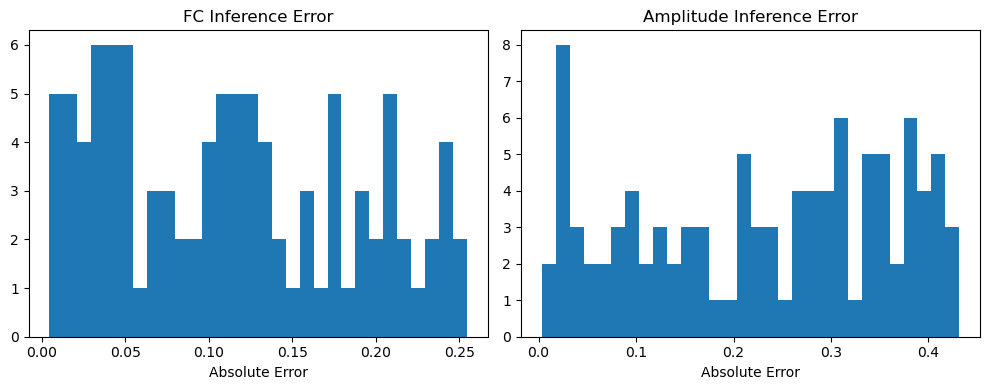

In [3]:

# --- Hyperparameters ---
latent_dim = 100
num_simulations = 1000
num_test_samples = 100

# ✅ Prior for fc and amp
prior = sbi_utils.BoxUniform(low=torch.tensor([0.01, 0.1]), high=torch.tensor([0.5, 1.0]))  # fc, amp

# ✅ Simulator using trained GAN
def simulator(theta):
    fc, amp = theta.numpy()

    # Simulate GAN output conditioned on fc, amp, is_qpo=1
    z = torch.randn((1, latent_dim))
    label = torch.tensor([[fc, amp, 1.0]], dtype=torch.float32)  # always QPO
    generated = generator([z, label], training=False).numpy().squeeze()

    # Power Spectrum
    f, Pxx = welch(generated, fs=1, nperseg=256)
    return torch.tensor(Pxx, dtype=torch.float32)

# ✅ Train SBI posterior
print("🧠 Running simulations...")
thetas = prior.sample((num_simulations,))
xs = torch.stack([simulator(theta) for theta in thetas])

inference = SNPE(prior)
density_estimator = inference.append_simulations(thetas, xs).train()
posterior = inference.build_posterior(density_estimator)
print("✅ SBI posterior trained!")

# ✅ Evaluate inference accuracy
true_vals = []
estimates = []

for _ in range(num_test_samples):
    # --- Sample true parameters
    theta_true = prior.sample((1,))
    fc_true, amp_true = theta_true.squeeze().numpy()

    # --- Generate synthetic QPO signal
    z = torch.randn((1, latent_dim))
    label = torch.tensor([[fc_true, amp_true, 1.0]], dtype=torch.float32)
    generated = generator([z, label], training=False).numpy().squeeze()

    # --- Compute observed PSD
    f, Pxx = welch(generated, fs=1, nperseg=256)
    x_obs = torch.tensor(Pxx, dtype=torch.float32)

    # --- Run posterior inference
    samples = posterior.sample((500,), x=x_obs)
    fc_est = samples[:, 0].mean().item()
    amp_est = samples[:, 1].mean().item()

    # --- Log results
    true_vals.append((fc_true, amp_true))
    estimates.append((fc_est, amp_est))

# ✅ Summary dataframe
summary_df = pd.DataFrame({
    "True_fc": [x[0] for x in true_vals],
    "Estimated_fc": [x[0] for x in estimates],
    "True_amp": [x[1] for x in true_vals],
    "Estimated_amp": [x[1] for x in estimates]
})

summary_df["fc_error"] = np.abs(summary_df["Estimated_fc"] - summary_df["True_fc"])
summary_df["amp_error"] = np.abs(summary_df["Estimated_amp"] - summary_df["True_amp"])

# ✅ Print summary stats
print(summary_df.describe())

# ✅ Save to CSV
summary_df.to_csv("sbi_qpo_inference_results.csv", index=False)
print("📁 Saved: sbi_qpo_inference_results.csv")

# ✅ Plot error histograms
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(summary_df["fc_error"], bins=30)
plt.title("FC Inference Error")
plt.xlabel("Absolute Error")

plt.subplot(1, 2, 2)
plt.hist(summary_df["amp_error"], bins=30)
plt.title("Amplitude Inference Error")
plt.xlabel("Absolute Error")

plt.tight_layout()
plt.show()


In [4]:
# Load x_obs from saved file
x_obs = torch.tensor(np.load("xmm_qpo_psd_obs.npy"), dtype=torch.float32)

# Run SBI inference
samples = posterior.sample((500,), x=x_obs)

# Extract means or visualize
fc_est = samples[:, 0].mean().item()
amp_est = samples[:, 1].mean().item()

print(f"🧠 Inferred fc:  {fc_est:.4f} Hz")
print(f"🧠 Inferred amp: {amp_est:.4f}")


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

🧠 Inferred fc:  0.2558 Hz
🧠 Inferred amp: 0.5475


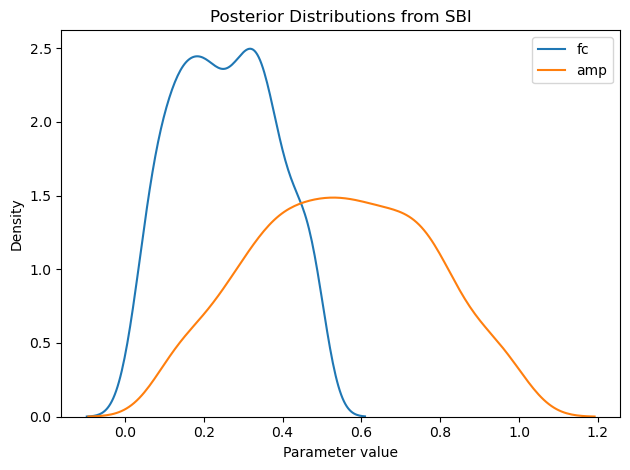

In [5]:
import seaborn as sns

sns.kdeplot(samples[:, 0].numpy(), label="fc")
sns.kdeplot(samples[:, 1].numpy(), label="amp")
plt.title("Posterior Distributions from SBI")
plt.xlabel("Parameter value")
plt.legend()
plt.tight_layout()
plt.show()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

🔬 SBI Sanity Test – Synthetic QPO
🎯 Known fc:  0.3500   | Inferred: 0.2400
🎯 Known amp: 0.6500 | Inferred: 0.5763


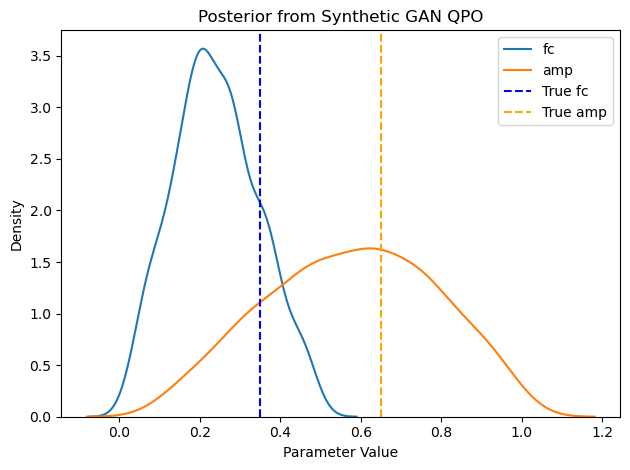

In [6]:
# %%
# ✅ Test SBI on a synthetic QPO from GAN with known fc and amp

# --- Known input parameters
fc_known = 0.35
amp_known = 0.65
label = torch.tensor([[fc_known, amp_known, 1.0]], dtype=torch.float32)

# --- Generate GAN output
z = torch.randn((1, latent_dim))
synthetic_qpo = generator([z, label], training=False).numpy().squeeze()

# --- Compute PSD
f, Pxx = welch(synthetic_qpo, fs=1, nperseg=256)
x_synth = torch.tensor(Pxx, dtype=torch.float32)

# --- Inference from synthetic QPO
synth_samples = posterior.sample((500,), x=x_synth)
fc_synth_est = synth_samples[:, 0].mean().item()
amp_synth_est = synth_samples[:, 1].mean().item()

print("🔬 SBI Sanity Test – Synthetic QPO")
print(f"🎯 Known fc:  {fc_known:.4f}   | Inferred: {fc_synth_est:.4f}")
print(f"🎯 Known amp: {amp_known:.4f} | Inferred: {amp_synth_est:.4f}")

# --- Plot Posterior
sns.kdeplot(synth_samples[:, 0].numpy(), label="fc")
sns.kdeplot(synth_samples[:, 1].numpy(), label="amp")
plt.axvline(fc_known, color='blue', linestyle='--', label="True fc")
plt.axvline(amp_known, color='orange', linestyle='--', label="True amp")
plt.title("Posterior from Synthetic GAN QPO")
plt.xlabel("Parameter Value")
plt.legend()
plt.tight_layout()
plt.show()
